In [1]:
import torch
import esm
import torch.nn as nn
from collections import OrderedDict
from tqdm import tqdm
import matplotlib.pyplot as plt
import utils
import importlib

importlib.reload(utils)
import pandas as pd
import numpy as np
import os

In [9]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def rsigmoid(x):
    return -np.log(1/x - 1)

In [6]:
a = np.arange(-5, 5, 0.2)
b = sigmoid(a)

In [12]:
a = np.array([0.01, 0.01, 0.01, 0.01, 0.99])
b = rsigmoid(a)
np.std(b)

3.6760958801076695

In [7]:
a = pd.DataFrame({'a': a, 'b': b})
a

,a,b
0,-5.000000e+00,0.006693
1,-4.800000e+00,0.008163
2,-4.600000e+00,0.009952
3,-4.400000e+00,0.012128
4,-4.200000e+00,0.014774
5,-4.000000e+00,0.017986
6,-3.800000e+00,0.021881
7,-3.600000e+00,0.026597
8,-3.400000e+00,0.032295
9,-3.200000e+00,0.039166


In [9]:
import re 
s = r"TM-(?P<start>\d+)-(?P<end>\d+)"

[('391', '413'), ('425', '447'), ('452', '474'), ('600', '622')]

In [10]:
import pickle 
with open("/data/tyfei/datasets/ion_channel/Interpro_v2/kingdom/Bacteria1.pkl", "rb") as f:
    q = pickle.load(f)
df = pd.DataFrame()
q[0].keys()

dict_keys(['randomseed', 'model', 'id', 'ori_seq', 'seq_t', 'structure_t', 'second_t', 'sasa_t', 'coordinates'])

In [ ]:
df = pd.read_excel("/data/tyfei/datasets/ion_channel/Interprot/annotation.xlsx", index_col=0)
df.head()
df["Ion_pendoplasmic_reticulummeability_label"] = df["Ion_pendoplasmic_reticulummeability_label"].astype(str)
df["Location"] = df["Location"].astype(str)
df["Gating"] = df["Gating"].astype(str)
# np.unique(df["Ion_pendoplasmic_reticulummeability_label"]), np.unique(df["Location"]), np.unique(df["Gating"])

In [16]:

for i in q:
    t = df.loc[i["id"]]
    thm = t["TMhelix Ranges"] 
    s = r"TM-(?P<start>\d+)-(?P<end>\d+)" 
    res = re.findall(s, thm) 
    ranges = [] 
    for j in res:
        ranges.append((int(j[0]), int(j[1])))
    print(ranges)
    i["Tmranges"] = ranges 
    classes = []
    if "Non-selective cation" in t["Ion_pendoplasmic_reticulummeability_label"]:
        classes.append(1) 
    else:
        classes.append(0)  
    if "Non-selective anion" in t["Ion_pendoplasmic_reticulummeability_label"]:
        classes.append(1) 
    else:
        classes.append(0)
    i["classes"] = classes 

[(26, 48), (63, 85), (106, 128), (164, 186), (198, 220), (230, 252)]
[(20, 41)]
[(26, 48), (92, 114)]
[(26, 48), (78, 100)]
[(13, 32), (65, 87)]
[(33, 50), (65, 87), (111, 133), (169, 191), (198, 220), (235, 257)]
[(13, 35), (50, 72)]
[(36, 58), (93, 115)]
[(20, 42)]
[(4, 26), (33, 55), (70, 92)]
[(7, 26), (36, 58), (65, 87), (97, 116)]
[(5, 22), (29, 51), (61, 83), (96, 113)]
[(13, 35), (50, 69)]
[(12, 31), (41, 63), (75, 97), (107, 126)]
[(5, 22), (35, 54), (69, 91), (104, 126)]
[(81, 103), (110, 132), (147, 169)]
[(2, 21), (31, 53), (60, 77), (92, 114)]
[(10, 32), (41, 63), (78, 100)]
[(30, 52), (67, 89)]
[(25, 47), (60, 82), (94, 116), (126, 148)]
[(37, 59), (69, 91), (103, 125), (135, 157)]
[(5, 22), (27, 49), (70, 87), (102, 124)]
[(33, 55), (68, 87), (97, 119)]
[(4, 26), (33, 55), (70, 88), (101, 123)]
[(63, 85), (97, 119), (129, 151)]
[(5, 27), (37, 59), (66, 88), (98, 120)]
[(33, 55), (68, 90), (100, 122)]
[(49, 71), (81, 103), (116, 133), (143, 165)]
[(10, 29), (41, 63), (73,

KeyError: 'A0A259NF20'

In [15]:
df

,Name,ScientificName,Protein_length,Entry_accession,Family_name,Gating,Ion_pendoplasmic_reticulummeability_label,Location,Source_database,TaxId,Taxonomy,TMH Count,TMhelix Ranges
Accession,,,,,,,,,,,,,
Q9XSC8,5-HT3 receptor,Oryctolagus cuniculus,158,IPR006201,Neurotransmittendoplasmic reticulum-gated ion-...,Ligand-gated,Non-selective cation,plasma membrane,interpro,9986,Eukaryota;Chordata;Mammalia;Lagomorpha;Leporid...,2,"TM-93-115,TM-130-152"
A0A6G1ADB1,5HT3A protein,Crocuta crocuta,625,IPR006201;IPR008132,Neurotransmittendoplasmic reticulum-gated ion-...,Ligand-gated,Non-selective cation,plasma membrane,interpro,9678,Eukaryota;Chordata;Mammalia;Carnivora;Hyaenida...,4,"TM-391-413,TM-425-447,TM-452-474,TM-600-622"
A0A7K8LKA5,5HT3A protein,Ardeotis kori,306,IPR006201;IPR008132,Neurotransmittendoplasmic reticulum-gated ion-...,Ligand-gated,Non-selective cation,plasma membrane,interpro,89386,Eukaryota;Chordata;Aves;Gruiformes;Otididae;Ar...,3,"TM-213-235,TM-247-269,TM-274-296"
A0A851A5Q0,5HT3A protein,Sula dactylatra,347,IPR006201;IPR008132,Neurotransmittendoplasmic reticulum-gated ion-...,Ligand-gated,Non-selective cation,plasma membrane,interpro,56068,Eukaryota;Chordata;Aves;Suliformes;Sulidae;Sul...,3,"TM-157-179,TM-191-213,TM-217-239"
A0A3Q4FYP4,5-hydroxytryptamine (serotonin) receptor 3A,Neolamprologus brichardi,407,IPR006201;IPR008132,Neurotransmittendoplasmic reticulum-gated ion-...,Ligand-gated,Non-selective cation,plasma membrane,interpro,32507,Eukaryota;Chordata;Actinopteri;Cichliformes;Ci...,5,"TM-203-225,TM-235-254,TM-261-283,TM-298-315,TM..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
A0A953A084,Zinc transporter ZntB,Sphaerobacter sp.,330,IPR045863,"CorA,transmembrane region",Magnesium,Zinc selectivity,plasma membrane,interpro,2099654,Bacteria;Thermomicrobiota;Thermomicrobia;Sphae...,2,"TM-266-288,TM-303-325"
A0A955RG90,Zinc transporter ZntB,Myxococcales bacterium,51,IPR045863,"CorA,transmembrane region",Magnesium,Zinc selectivity,plasma membrane,interpro,2026763,Bacteria;Myxococcota;Myxococcia;Myxococcales;;...,1,TM-23-45
A0A957WJS6,Zinc transporter ZntB,Anaerolineae bacterium,61,IPR045863,"CorA,transmembrane region",Magnesium,Zinc selectivity,plasma membrane,interpro,2052143,Bacteria;Chloroflexota;Anaerolineae;;;;Anaerol...,2,"TM-5-27,TM-37-59"


In [17]:
df.head()

,Name,ScientificName,Protein_length,Entry_accession,Family_name,Gating,Ion_pendoplasmic_reticulummeability_label,Location,Source_database,TaxId,Taxonomy,TMH Count,TMhelix Ranges
Accession,,,,,,,,,,,,,
Q9XSC8,5-HT3 receptor,Oryctolagus cuniculus,158,IPR006201,Neurotransmittendoplasmic reticulum-gated ion-...,Ligand-gated,Non-selective cation,plasma membrane,interpro,9986,Eukaryota;Chordata;Mammalia;Lagomorpha;Leporid...,2,"TM-93-115,TM-130-152"
A0A6G1ADB1,5HT3A protein,Crocuta crocuta,625,IPR006201;IPR008132,Neurotransmittendoplasmic reticulum-gated ion-...,Ligand-gated,Non-selective cation,plasma membrane,interpro,9678,Eukaryota;Chordata;Mammalia;Carnivora;Hyaenida...,4,"TM-391-413,TM-425-447,TM-452-474,TM-600-622"
A0A7K8LKA5,5HT3A protein,Ardeotis kori,306,IPR006201;IPR008132,Neurotransmittendoplasmic reticulum-gated ion-...,Ligand-gated,Non-selective cation,plasma membrane,interpro,89386,Eukaryota;Chordata;Aves;Gruiformes;Otididae;Ar...,3,"TM-213-235,TM-247-269,TM-274-296"
A0A851A5Q0,5HT3A protein,Sula dactylatra,347,IPR006201;IPR008132,Neurotransmittendoplasmic reticulum-gated ion-...,Ligand-gated,Non-selective cation,plasma membrane,interpro,56068,Eukaryota;Chordata;Aves;Suliformes;Sulidae;Sul...,3,"TM-157-179,TM-191-213,TM-217-239"
A0A3Q4FYP4,5-hydroxytryptamine (serotonin) receptor 3A,Neolamprologus brichardi,407,IPR006201;IPR008132,Neurotransmittendoplasmic reticulum-gated ion-...,Ligand-gated,Non-selective cation,plasma membrane,interpro,32507,Eukaryota;Chordata;Actinopteri;Cichliformes;Ci...,5,"TM-203-225,TM-235-254,TM-261-283,TM-298-315,TM..."


In [12]:
cri = torch.nn.BCEWithLogitsLoss() 
a = torch.randn(4, 3) 
b = torch.tensor([[1,0,1],[1,1,0],[0,1,1],[1,1,1]], dtype=torch.float)
cri(a, b)

tensor(0.7219)

In [4]:
a, b

(tensor([[ 0.2584,  1.9682, -0.9857],
         [-0.0147,  0.7607, -0.5430],
         [ 0.7520,  0.0216,  0.3524],
         [ 0.2290, -0.7621,  0.4337]]),
 tensor([[1, 0, 1],
         [1, 1, 0],
         [0, 1, 1],
         [1, 1, 1]]))

In [31]:
# Load ESM-2 model
model, alphabet = esm.pretrained.esm2_t12_35M_UR50D()
batch_converter = alphabet.get_batch_converter()
model.eval()  # disables dropout for deterministic results

# Prepare data (first 2 sequences from ESMStructuralSplitDataset superfamily / 4)
data = [
    ("protein1", "MKTVRQERLKSIVRILERSKEPVSGAQLAEELSVSRQVIVQDIAYLRSLGYNIVATPRGYVLAGG"),
    (
        "protein2",
        "KALTARQQEVFDLIRDHISQTGMPPTRAEIAQRLGFRSPNAAEEHLKALARKGVIEIVSGASRGIRLLQEE",
    ),
    (
        "protein2 with mask",
        "KALTARQQEVFDLIRD<mask>ISQTGMPPTRAEIAQRLGFRSPNAAEEHLKALARKGVIEIVSGASRGIRLLQEE",
    ),
    ("protein3", "K A <mask> I S Q"),
]
batch_labels, batch_strs, batch_tokens = batch_converter(data)
batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)

# Extract per-residue representations (on CPU)
with torch.no_grad():
    results = model(batch_tokens, repr_layers=[12], return_contacts=True)
token_representations = results["representations"][12]

# Generate per-sequence representations via averaging
# NOTE: token 0 is always a beginning-of-sequence token, so the first residue is token 1.
sequence_representations = []
for i, tokens_len in enumerate(batch_lens):
    sequence_representations.append(
        token_representations[i, 1 : tokens_len - 1].mean(0)
    )

In [7]:
df = pd.read_excel("/home/tyfei/datasets/ion_channel/Interprot/Interprot-ion-channel-judgement.xls")
df = df.set_index("Accession")
df["has"] = 0
# df.loc[["IPR006859", "IPR008187", "IPR043506", "IPR043507"]]

,Name,Description,Source Database,Has_Transmembrane_Region
Accession,,,,
SM01420,Transient receptor ion channel II,This domain is found in the transient receptor...,SMART,True
PF08344,Transient receptor ion channel II,This domain is found in the transient receptor...,PFAM,True
IPR013555,Transient receptor ion channel domain,This domain is found in a group of Trp protein...,INTERPRO,True
IPR024393,"Mechanosensitive ion channel MscS, porin domain","The small mechanosensitive channel, MscS, is a...",INTERPRO,True
PF12794,Mechanosensitive ion channel inner membrane do...,"The small mechanosensitive channel, MscS, is a...",PFAM,True
...,...,...,...,...
IPR001069,5-Hydroxytryptamine 7 receptor,"5-hydroxytryptamine (5-HT) or serotonin, is a ...",INTERPRO,True
IPR002232,5-Hydroxytryptamine 6 receptor,"5-hydroxytryptamine (5-HT) or serotonin, is a ...",INTERPRO,True
IPR000377,5-Hydroxytryptamine 2C receptor,"5-hydroxytryptamine (5-HT) or serotonin, is a ...",INTERPRO,True


In [34]:
seqs = {} 
seqs["virus_seq"] = utils.readDataset("/home/tyfei/datasets/ion_channel/Known_Virus_Ion_pro/all_Known_Virus_Ion_pro.rename_0.99.fasta", trunc=1200) 
seqs["negative"] = utils.readDataset("/home/tyfei/datasets/ion_channel/Interprot/Negative_sample/decoy_1m_new.fasta", 30000, 1200)

In [20]:
lens = [] 
for j in seqs:
    lens.append(len(seqs[j]))
    # for i in seqs[j]:
    #     lens.append(len(i[1]))
    #     if len(i[1]) > 1300:
    #         print(j, len(i[1]), i)
len(lens), np.max(lens)

(1, 30000)

In [35]:
# seqs = {}
for i in os.listdir("/home/tyfei/datasets/ion_channel/Interprot/ion_channel/0.99"):
    try:
        if i.endswith(".fas"):
            # print(i, i[:i.find(".")] in df["Accession"].values)
            seqs[i[:i.find(".")]] = utils.readDataset("/home/tyfei/datasets/ion_channel/Interprot/ion_channel/0.99/"+i, samplenum=300, trunc=1200)
        df.at[i[:i.find(".")], "has"] = len(seqs[i[:i.find(".")]])
    except:
        print(i)

IPR048786.fasta.0.99.fas.clstr
PF00654.fasta.0.99.fas.clstr
IPR003967.fasta.0.99.fas.clstr
IPR006859.fasta.0.99.fas.clstr
IPR008187.fasta.0.99.fas.clstr
IPR030259.fasta.0.99.fas.clstr
IPR020383.fasta.0.99.fas.clstr
IPR008348.fasta.0.99.fas.clstr
IPR003971.fasta.0.99.fas.clstr
PF11504.fasta.0.99.fas.clstr
IPR003279.fasta.0.99.fas.clstr
cd15238.fasta.0.99.fas.clstr
TIGR00870.fasta.0.99.fas.clstr
IPR005408.fasta.0.99.fas.clstr
PF16799.fasta.0.99.fas.clstr
cd11861.fasta.0.99.fas.clstr
IPR028823.fasta.0.99.fas.clstr
cd18594.fasta.0.99.fas.clstr
IPR019823.fasta.0.99.fas.clstr
cd16965.fasta.0.99.fas.clstr
IPR024701.fasta.0.99.fas.clstr
IPR005409.fasta.0.99.fas.clstr
IPR044377.fasta.0.99.fas.clstr
IPR003269.fasta.0.99.fas.clstr
cd20328.fasta.0.99.fas.clstr
IPR002147.fasta.0.99.fas.clstr
PF05978.fasta.0.99.fas.clstr
IPR004726.fasta.0.99.fas.clstr
IPR035940.fasta.0.99.fas.clstr
cd19056.fasta.0.99.fas.clstr
IPR003948.fasta.0.99.fas.clstr
PS51926.fasta.0.99.fas.clstr
IPR004053.fasta.0.99.fas.clstr

In [36]:
filtered = []
labels = [] 

for i, tt in seqs.items():
    labels.extend([i]*len(tt))
    for name, seq in tt:
        if "*" in seq:
            filtered.append((name, seq[:-1].upper()))
        else:
            filtered.append((name, seq.upper()))

In [37]:
len(labels), len(filtered)

(83773, 83773)

In [38]:
batch_labels, _, batch_tokens = batch_converter(filtered)

In [ ]:
import os 
import json
import models
path = "/home/tyfei/ionChannel/ckpts/fix3/"
# strategy = L.strategies.DeepSpeedStrategy()
k = 2
with open(os.path.join(path, "config.json"), "r") as f:
    configs = json.load(f)
    
model, alphabet = esm.pretrained.esm2_t12_35M_UR50D()
model = models.fixParameters(model, unfix=configs["pretrain_model"]["unfix_layers"])
model = models.addlora(
    model,
    layers=configs["pretrain_model"]["add_lora"],
    ranks=configs["pretrain_model"]["rank"],
    alphas=configs["pretrain_model"]["alpha"],
)
clsmodel = models.ionclf(
    model,
    step_lambda=configs["model"]["lambda_adapt"],
    lamb=configs["model"]["lambda_ini"],
    max_lambda=configs["model"]["max_lambda"],
    step=configs["model"]["lambda_step"],
    p=configs["model"]["dropout"],
    thres=configs["model"]["lambda_thres"],
    lr=configs["model"]["lr"],
)



In [ ]:
batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)
model = model.to("cuda:5")
batch_tokens = batch_tokens.to("cuda:5")
# Extract per-residue representations (on CPU)
allres = []
for i in tqdm(range(0, len(batch_tokens), 10)):
    with torch.no_grad():
        results = model(
            batch_tokens[i : i + 10], repr_layers=[12], return_contacts=False
        )
        token_representations = results["representations"][12].cpu().numpy()
        allres.append(token_representations)

 38%|███▊      | 3202/8341 [10:34<16:59,  5.04it/s]


KeyboardInterrupt: 

In [10]:
import numpy as np 
allres = np.concatenate(allres, axis=0)
allres.shape

(67862, 1202, 480)

In [11]:
sequence_representations = []
for i, tokens_len in enumerate(batch_lens):
    sequence_representations.append(allres[i, 1 : tokens_len - 1].mean(0))
sequence_representations = np.array(sequence_representations)
# sequence_representations

In [12]:
from sklearn.decomposition import PCA

pca = PCA(n_components=20)
pca_seq = pca.fit_transform(sequence_representations)
pca_seq.shape

(67862, 20)

In [13]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(pca_seq)

In [25]:
df = pd.DataFrame({"x": X_embedded[:, 0], "y": X_embedded[:, 1], "labels": labels})
mapping = {}
for i in np.unique(df["labels"]):
    mapping[i] = len(mapping)
df["labels"] = df["labels"].apply(lambda x: "negative" if x == "nagative" else x)
df["c"] = df["labels"].map(mapping)
df["negative"] = (df["labels"] == "negative").astype(int)
df["virus_seq"] = (df["labels"] == "virus_seq").astype(int)

In [27]:
df.to_csv("./temp/data.csv")

In [2]:
df = pd.read_csv("./temp/trained_data.csv")

negative


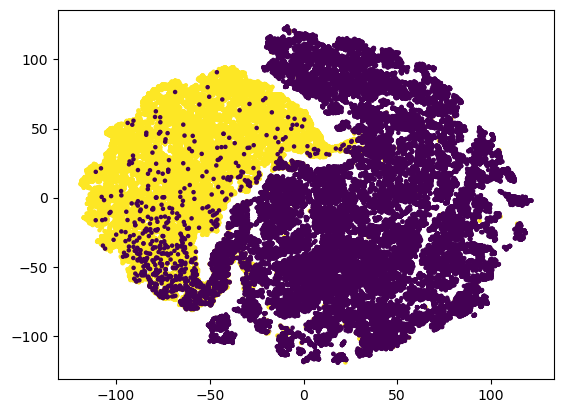

virus_seq


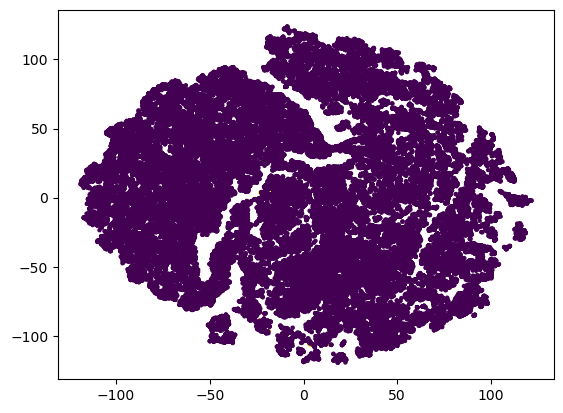

In [3]:
subdf = df#[df["labels"] != "negative"]
for i in ["negative", "virus_seq"]:#np.unique(df["labels"]):
    # if i == "negative":
    #     continue
    # if i == "virus_seq":
    #     continue
    print(i)
    subdf["draw"] = (subdf["labels"] == i).astype(int)
    # subdf = df[df["labels"] != "negative"]
    # subdf = subdf[subdf["virus_seq"] == i]
    plt.scatter(subdf["x"], subdf["y"], c=subdf["draw"], label=subdf["draw"], s=5)
    plt.show()
    plt.close()

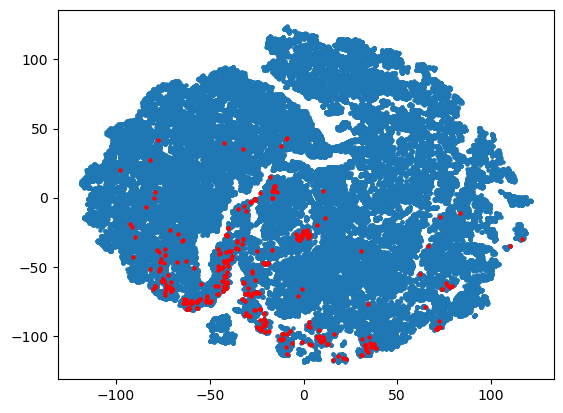

In [12]:
subdf = df[df["draw"] == 0]
plt.scatter(subdf["x"], subdf["y"], label=subdf["draw"], s=5)
subdf = df[df["draw"] == 1]
plt.scatter(subdf["x"], subdf["y"], label=subdf["draw"], c="red",s=5)

0
1


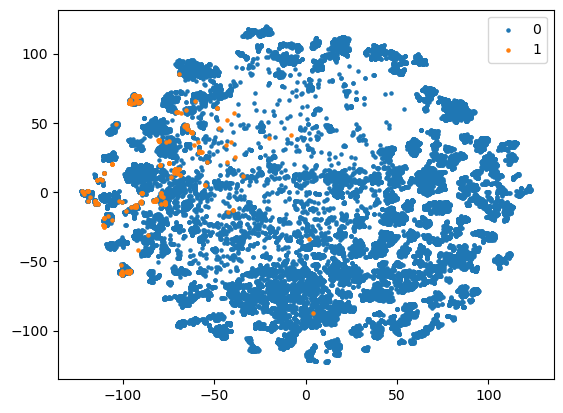

In [29]:
# c = [0]*50000+[1]*369
for i in np.unique(df["virus_seq"]):
    # if i == "negative":
    #     continue
    # if i == "virus_seq":
    #     continue
    print(i)
    subdf = df[df["labels"] != "negative"]
    subdf = subdf[subdf["virus_seq"] == i]
    plt.scatter(subdf["x"], subdf["y"], label=i, s=5)
plt.legend(bbox_to_anchor=(1, 1))

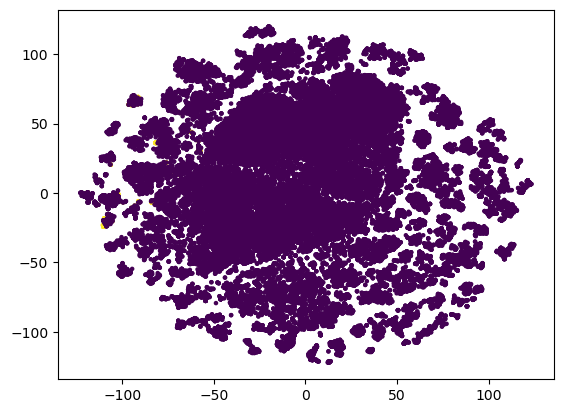

In [116]:
plt.scatter(df["x"], df["y"], c=df["virus_seq"], s=5)

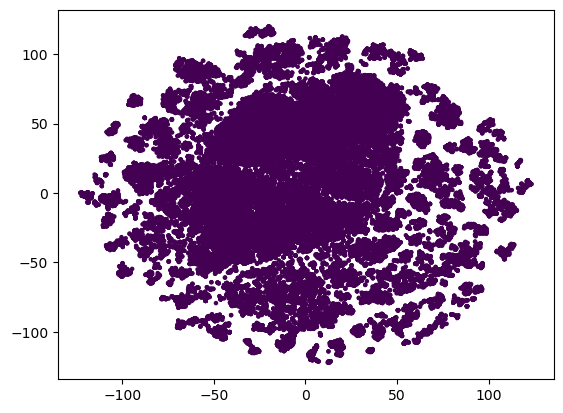

In [117]:
plt.scatter(df["x"], df["y"], c=df["negative"], s=5)